In [2]:
from ray import tune


def objective(config):  # ①
    score = config["a"] ** 2 + config["b"]
    return {"score": score}


search_space = {  # ②
    "a": tune.grid_search([0.001, 0.01, 0.1, 1.0]),
    "b": tune.choice([1, 2, 3]),
}

tuner = tune.Tuner(objective, param_space=search_space)  # ③

results = tuner.fit()
print(results.get_best_result(metric="score", mode="min").config)

2025-07-12 15:24:31,570	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/qrbao/ray_results/objective_2025-07-12_15-24-30' in 0.0063s.
2025-07-12 15:24:31,574	INFO tune.py:1041 -- Total run time: 0.82 seconds (0.81 seconds for the tuning loop).


{'a': 0.01, 'b': 1}


In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler

2025-07-12 15:30:59,756	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-07-12 15:30:59,929	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [9]:
# def train_and_test():
#     # 训练阶段
#     model.train()              # 学习模式
#     for batch in train_loader:
#         optimizer.zero_grad()
#         loss = compute_loss(batch)
#         loss.backward()        # 计算梯度
#         optimizer.step()       # 更新参数
    
#     # 测试阶段
#     model.eval()               # 预测模式
#     with torch.no_grad():      # 不计算梯度
#         for batch in test_loader:
#             accuracy = compute_accuracy(batch)

In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 512
TEST_SIZE = 256

def train_func(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

import os
import tempfile

from ray.tune import Checkpoint

def train_mnist(config):
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train_func(model, optimizer, train_loader)
        acc = test_func(model, test_loader)


        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if (i + 1) % 5 == 0:
                # This saves the model to the trial directory
                torch.save(
                    model.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            # Send the current training result back to Tune
            tune.report({"mean_accuracy": acc}, checkpoint=checkpoint)
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9),
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.MNIST("~/data", train=True, download=True)


2025-07-12 17:25:35,036	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-07-12 17:25:35,207	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/qrbao/data
    Split: Train

In [2]:

tuner = tune.Tuner(
    train_mnist,
    param_space=search_space,
)


In [3]:
results = tuner.fit()


(train_mnist pid=2440143) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/qrbao/ray_results/train_mnist_2025-07-12_17-25-37/train_mnist_cbabc_00000_0_momentum=0.4481_2025-07-12_17-25-40/checkpoint_000000)
2025-07-12 17:25:43,446	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/qrbao/ray_results/train_mnist_2025-07-12_17-25-37' in 0.0018s.
2025-07-12 17:25:43,448	INFO tune.py:1041 -- Total run time: 2.93 seconds (2.89 seconds for the tuning loop).


(train_mnist pid=2440143) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/qrbao/ray_results/train_mnist_2025-07-12_17-25-37/train_mnist_cbabc_00000_0_momentum=0.4481_2025-07-12_17-25-40/checkpoint_000001)


[<Axes: >]

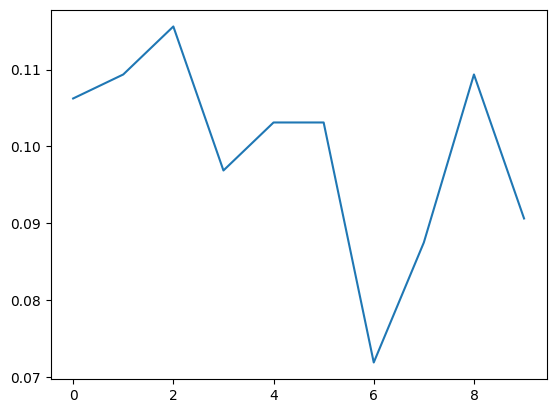

In [4]:
dfs = {result.path: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]

## this is differenct algorithm running on the game 

In [4]:
import ray
from ray.rllib.algorithms.ppo import PPOConfig

# 初始化 Ray（local mode 适合 debug）
ray.init(local_mode=True,ignore_reinit_error=True)

# 创建一个 PPO 配置
config = (
    PPOConfig()
    .environment("CartPole-v1")   # 指定环境
    .framework("torch")           # 使用 torch，也可以是 "tf2"
    .env_runners(num_env_runners=0)  # 关闭并行采样
    .training(train_batch_size=4000)
)

# 构建 PPO 算法对象
algo = config.build()

# 训练循环
for i in range(100):
    result = algo.train()
    reward = result["env_runners"]["episode_return_mean"]
    print(f"Iteration {i}: reward={reward}")
    if reward >= 200:
        print("🎉 Solved CartPole!")
        break

# 清理资源
algo.stop()
ray.shutdown()


2025-07-15 12:30:31,163	INFO worker.py:1747 -- Calling ray.init() again after it has already been called.
2025-07-15 12:30:31,163	WARNING deprecation.py:50 -- DeprecationWarning: `build` has been deprecated. Use `AlgorithmConfig.build_algo` instead. This will raise an error in the future!
2025-07-15 12:30:31,165	WARNING algorithm_config.py:5014 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/home/qrbao/anaconda3/envs/rllib/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:520: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`Unifie

Iteration 0: reward=23.35
Iteration 1: reward=35.69
Iteration 2: reward=52.28
Iteration 3: reward=78.58
Iteration 4: reward=106.57
Iteration 5: reward=136.01
Iteration 6: reward=166.57
Iteration 7: reward=200.77
🎉 Solved CartPole!
